# Forest Cover Type Classification

This notebook addresses the assignment requirements:
- **Part A**: 2D Logistic Regression with 2 features and 3 classes
- **Part B**: Overfitting analysis with regularization parameter tuning

## Data Loading and Initial Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv("covtype.csv")
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (581012, 55)

First few rows:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Data Preprocessing

In [3]:
# Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

print("Original dataset shape:", X.shape)
print("Target classes:", sorted(y.unique()))
print("\nClass distribution:")
print(y.value_counts().sort_index())

Original dataset shape: (581012, 54)
Target classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Class distribution:
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


In [4]:
# Identify continuous and binary features
continuous_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
                      'Horizontal_Distance_To_Fire_Points']

binary_features = [col for col in X.columns if col not in continuous_features]

print("Continuous features:", len(continuous_features))
print("Binary features (dummy variables):", len(binary_features))
print("\nTotal features:", len(X.columns))

Continuous features: 10
Binary features (dummy variables): 44

Total features: 54


In [5]:
# Sample the dataset to reduce computational cost (20% of data)
sample_size = int(0.2 * len(df))
print(f"Reducing dataset from {len(df)} to {sample_size} samples")

X_sample, _, y_sample, _ = train_test_split(
    X, y, test_size=0.8, stratify=y, random_state=42
)

print(f"Sampled dataset shape: {X_sample.shape}")
print("Sampled class distribution:")
print(y_sample.value_counts().sort_index())

Reducing dataset from 581012 to 116202 samples
Sampled dataset shape: (116202, 54)
Sampled class distribution:
Cover_Type
1    42368
2    56660
3     7151
4      549
5     1899
6     3473
7     4102
Name: count, dtype: int64
Sampled dataset shape: (116202, 54)
Sampled class distribution:
Cover_Type
1    42368
2    56660
3     7151
4      549
5     1899
6     3473
7     4102
Name: count, dtype: int64


In [6]:
# Split: 70% train, 15% test, 15% validation
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Dataset splits:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Validation set: {X_val.shape}")

Dataset splits:
Training set: (81341, 54)
Test set: (17430, 54)
Validation set: (17431, 54)


In [7]:
# Scale continuous features
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_val_scaled = X_val.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])

print("Feature scaling completed.")
print("Continuous features have been standardized (mean=0, std=1)")
print("Binary features remain unchanged")

Feature scaling completed.
Continuous features have been standardized (mean=0, std=1)
Binary features remain unchanged


## Part A: 2D Logistic Regression with 2 Features and 3 Classes

**Assignment Requirement:**  
Consider only two features and three classes and train Logistic Regression 3-class classifier (any three class) to show the training and test accuracy plot in a 2D plane, using matplotlib.

In [8]:
# Select top 3 classes based on frequency
top_3_classes = y_train.value_counts().head(3).index.tolist()
print("Selected 3 classes:", top_3_classes)
print("\nClass counts:")
for cls in top_3_classes:
    count = (y_train == cls).sum()
    print(f"  Class {cls}: {count} samples")

# Filter data for top 3 classes first (needed for feature selection)
mask_train_3class = y_train.isin(top_3_classes)
X_train_3class = X_train_scaled[mask_train_3class]
y_train_3class_temp = y_train[mask_train_3class]

# Use Sequential Forward Feature Selection to select 2 most informative features
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

print("\nPerforming Sequential Forward Feature Selection...")
print("This may take a moment as it evaluates feature combinations...\n")

# Create a base estimator for feature selection
base_estimator = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    max_iter=1000
)

# Perform forward feature selection on continuous features only
sfs = SequentialFeatureSelector(
    base_estimator,
    n_features_to_select=2,
    direction='forward',
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit the selector on continuous features
sfs.fit(X_train_3class[continuous_features], y_train_3class_temp)

# Get selected feature names
selected_features_mask = sfs.get_support()
selected_2_features = [continuous_features[i] for i, selected in enumerate(selected_features_mask) if selected]

print("Sequential Forward Feature Selection completed!")
print(f"\nSelected 2 most informative features: {selected_2_features}")
print(f"\nThese features were selected based on their contribution to classification accuracy")
print(f"using forward selection with 3-fold cross-validation.")

Selected 3 classes: [2, 1, 3]

Class counts:
  Class 2: 39662 samples
  Class 1: 29658 samples
  Class 3: 5006 samples

Performing Sequential Forward Feature Selection...
This may take a moment as it evaluates feature combinations...


Performing Sequential Forward Feature Selection...
This may take a moment as it evaluates feature combinations...

Sequential Forward Feature Selection completed!

Selected 2 most informative features: ['Elevation', 'Horizontal_Distance_To_Hydrology']

These features were selected based on their contribution to classification accuracy
using forward selection with 3-fold cross-validation.
Sequential Forward Feature Selection completed!

Selected 2 most informative features: ['Elevation', 'Horizontal_Distance_To_Hydrology']

These features were selected based on their contribution to classification accuracy
using forward selection with 3-fold cross-validation.


In [9]:
# Filter data for the selected 3 classes and 2 features
mask_train = y_train.isin(top_3_classes)
mask_test = y_test.isin(top_3_classes)
mask_val = y_val.isin(top_3_classes)

X_train_2d = X_train_scaled.loc[mask_train, selected_2_features].values
X_test_2d = X_test_scaled.loc[mask_test, selected_2_features].values
X_val_2d = X_val_scaled.loc[mask_val, selected_2_features].values

y_train_3class = y_train[mask_train]
y_test_3class = y_test[mask_test]
y_val_3class = y_val[mask_val]

print(f"Filtered dataset shapes:")
print(f"  Training: {X_train_2d.shape}")
print(f"  Test: {X_test_2d.shape}")
print(f"  Validation: {X_val_2d.shape}")

Filtered dataset shapes:
  Training: (74326, 2)
  Test: (15926, 2)
  Validation: (15927, 2)


In [10]:
# Train Logistic Regression for 3-class classification with 2 features
log_reg_2d = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    max_iter=1000
)

# Fit the model
log_reg_2d.fit(X_train_2d, y_train_3class)

# Make predictions
y_train_pred_2d = log_reg_2d.predict(X_train_2d)
y_test_pred_2d = log_reg_2d.predict(X_test_2d)
y_val_pred_2d = log_reg_2d.predict(X_val_2d)

# Calculate accuracies
train_acc_2d = accuracy_score(y_train_3class, y_train_pred_2d)
test_acc_2d = accuracy_score(y_test_3class, y_test_pred_2d)
val_acc_2d = accuracy_score(y_val_3class, y_val_pred_2d)

print("="*60)
print("2D 3-Class Logistic Regression Results")
print("="*60)
print(f"Training Accuracy:   {train_acc_2d:.4f}")
print(f"Test Accuracy:       {test_acc_2d:.4f}")
print(f"Validation Accuracy: {val_acc_2d:.4f}")
print("="*60)

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test_3class, y_test_pred_2d))

2D 3-Class Logistic Regression Results
Training Accuracy:   0.7410
Test Accuracy:       0.7412
Validation Accuracy: 0.7359

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.72      0.69      0.70      6355
           2       0.75      0.78      0.76      8499
           3       0.85      0.72      0.78      1072

    accuracy                           0.74     15926
   macro avg       0.77      0.73      0.75     15926
weighted avg       0.74      0.74      0.74     15926



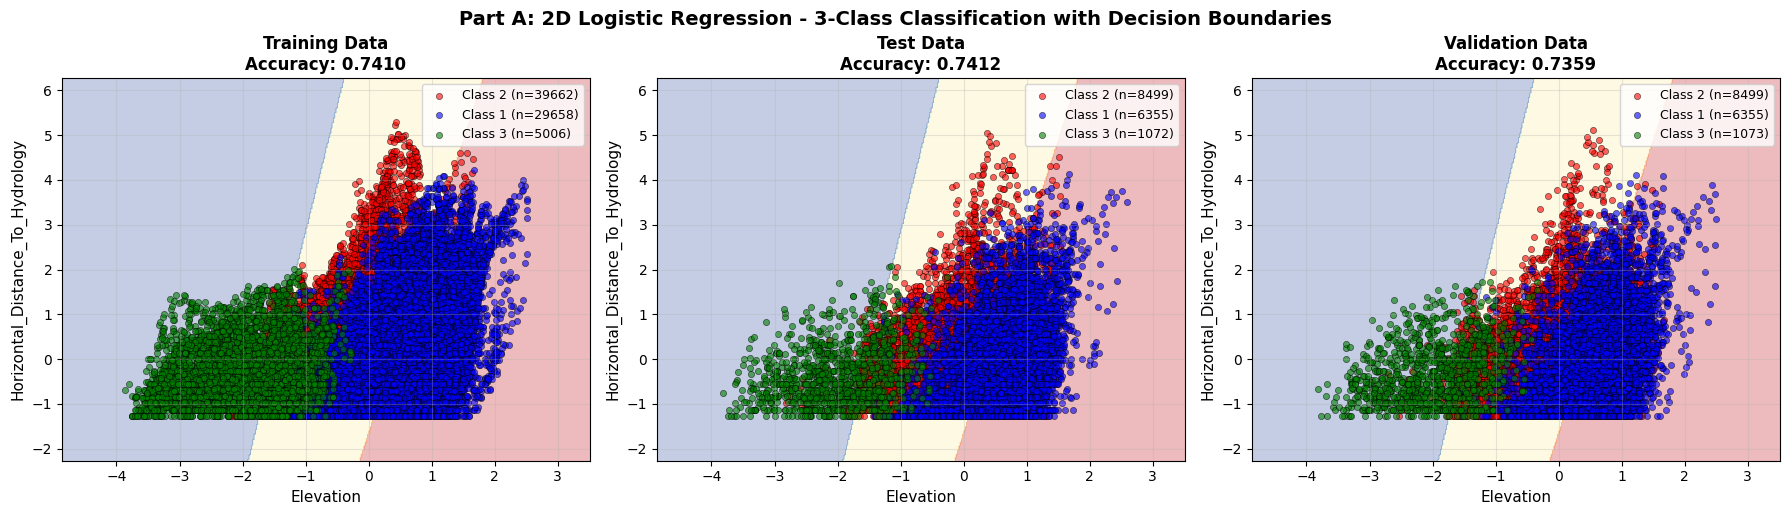


Visualization shows decision boundaries separating the 3 classes in 2D feature space.


In [11]:
# Visualize decision boundaries in 2D plane
plt.figure(figsize=(18, 5))

# Create mesh for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z = log_reg_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

colors = ['red', 'blue', 'green']
class_labels = [f'Class {cls}' for cls in top_3_classes]

# Plot 1: Training Data with Decision Boundaries
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
for i, cls in enumerate(top_3_classes):
    idx = y_train_3class == cls
    plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], 
                c=colors[i], label=f'{class_labels[i]} (n={idx.sum()})', 
                alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
plt.xlabel(selected_2_features[0], fontsize=11)
plt.ylabel(selected_2_features[1], fontsize=11)
plt.title(f'Training Data\nAccuracy: {train_acc_2d:.4f}', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 2: Test Data with Decision Boundaries
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
for i, cls in enumerate(top_3_classes):
    idx = y_test_3class == cls
    plt.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], 
                c=colors[i], label=f'{class_labels[i]} (n={idx.sum()})', 
                alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
plt.xlabel(selected_2_features[0], fontsize=11)
plt.ylabel(selected_2_features[1], fontsize=11)
plt.title(f'Test Data\nAccuracy: {test_acc_2d:.4f}', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 3: Validation Data with Decision Boundaries
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
for i, cls in enumerate(top_3_classes):
    idx = y_val_3class == cls
    plt.scatter(X_val_2d[idx, 0], X_val_2d[idx, 1], 
                c=colors[i], label=f'{class_labels[i]} (n={idx.sum()})', 
                alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
plt.xlabel(selected_2_features[0], fontsize=11)
plt.ylabel(selected_2_features[1], fontsize=11)
plt.title(f'Validation Data\nAccuracy: {val_acc_2d:.4f}', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Part A: 2D Logistic Regression - 3-Class Classification with Decision Boundaries', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print(f"\nVisualization shows decision boundaries separating the 3 classes in 2D feature space.")

## Part B: Overfitting Analysis with Regularization

**Assignment Requirement:**  
Analyze and control the overfitting by varying the inverse of regularization strength parameter (0.1, 0.25, 0.5, 0.75, 0.9) and plot the accuracy graph for the test set.

In [12]:
# Test different C values (inverse of regularization strength)
C_values = [0.1, 0.25, 0.5, 0.75, 0.9]
train_accuracies_reg = []
test_accuracies_reg = []
val_accuracies_reg = []

print("Training models with different C values (inverse regularization strength)...")
print("="*75)
print(f"{'C value':<10} {'Train Acc':<12} {'Test Acc':<12} {'Val Acc':<12} {'Overfitting Gap':<15}")
print("="*75)

for C in C_values:
    # Train logistic regression with different C values
    log_reg_c = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=C,
        random_state=42,
        max_iter=1000
    )
    
    # Fit the model
    log_reg_c.fit(X_train_2d, y_train_3class)
    
    # Calculate accuracies
    train_acc = log_reg_c.score(X_train_2d, y_train_3class)
    test_acc = log_reg_c.score(X_test_2d, y_test_3class)
    val_acc = log_reg_c.score(X_val_2d, y_val_3class)
    
    # Store accuracies
    train_accuracies_reg.append(train_acc)
    test_accuracies_reg.append(test_acc)
    val_accuracies_reg.append(val_acc)
    
    gap = train_acc - test_acc
    
    print(f"{C:<10.2f} {train_acc:<12.4f} {test_acc:<12.4f} {val_acc:<12.4f} {gap:<15.4f}")

print("="*75)
print(f"\nCompleted training for all C values.")
print(f"\nNote: Higher C = weaker regularization (more prone to overfitting)")
print(f"      Lower C = stronger regularization (simpler model)")

Training models with different C values (inverse regularization strength)...
C value    Train Acc    Test Acc     Val Acc      Overfitting Gap
0.10       0.7412       0.7412       0.7360       -0.0000        
0.25       0.7411       0.7412       0.7360       -0.0001        
0.10       0.7412       0.7412       0.7360       -0.0000        
0.25       0.7411       0.7412       0.7360       -0.0001        
0.50       0.7410       0.7412       0.7358       -0.0001        
0.75       0.7410       0.7412       0.7359       -0.0001        
0.50       0.7410       0.7412       0.7358       -0.0001        
0.75       0.7410       0.7412       0.7359       -0.0001        
0.90       0.7410       0.7412       0.7359       -0.0002        

Completed training for all C values.

Note: Higher C = weaker regularization (more prone to overfitting)
      Lower C = stronger regularization (simpler model)
0.90       0.7410       0.7412       0.7359       -0.0002        

Completed training for all C value

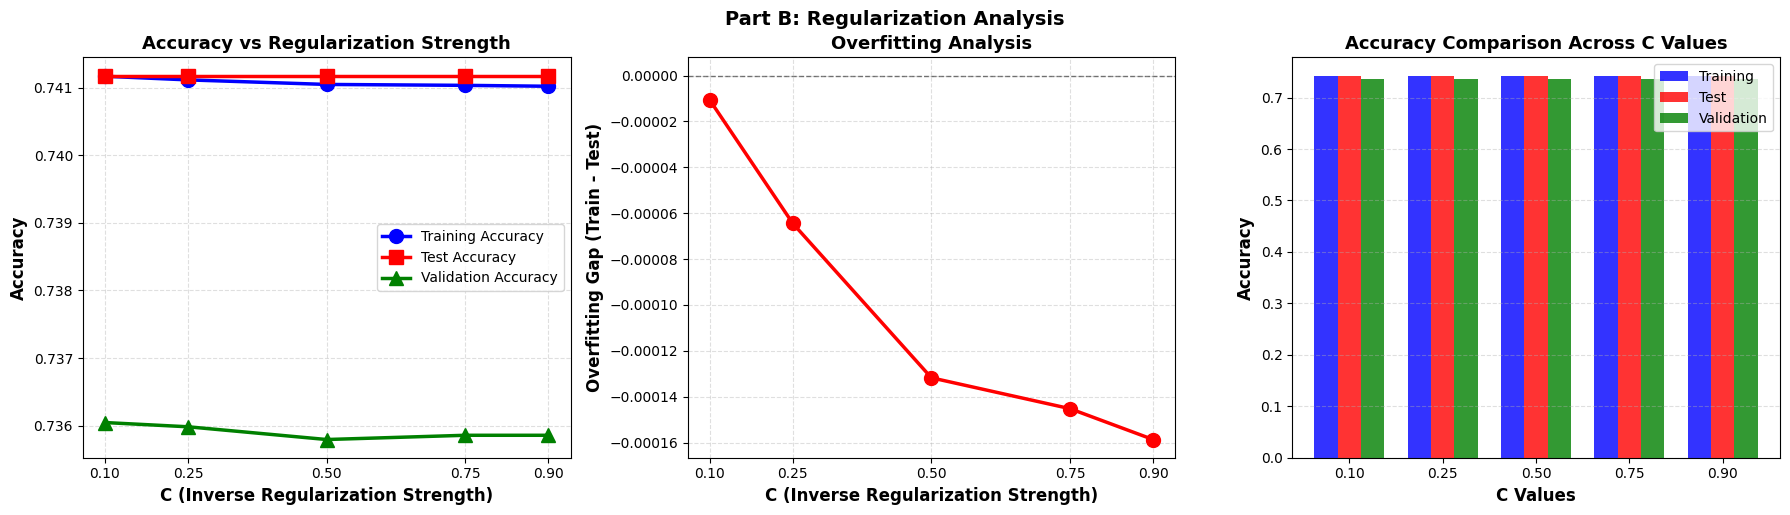


REGULARIZATION ANALYSIS RESULTS
Optimal C value (based on test accuracy): 0.1
Best test accuracy: 0.7412
Training accuracy at optimal C: 0.7412
Overfitting gap at optimal C: -0.0000


In [13]:
# Visualize regularization effects
plt.figure(figsize=(18, 5))

# Plot 1: Training, Test, and Validation Accuracy vs C
plt.subplot(1, 3, 1)
plt.plot(C_values, train_accuracies_reg, 'o-', label='Training Accuracy', 
         linewidth=2.5, markersize=10, color='blue')
plt.plot(C_values, test_accuracies_reg, 's-', label='Test Accuracy', 
         linewidth=2.5, markersize=10, color='red')
plt.plot(C_values, val_accuracies_reg, '^-', label='Validation Accuracy', 
         linewidth=2.5, markersize=10, color='green')
plt.xlabel('C (Inverse Regularization Strength)', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Accuracy vs Regularization Strength', fontsize=13, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(C_values)

# Plot 2: Overfitting Gap vs C
training_test_gap = np.array(train_accuracies_reg) - np.array(test_accuracies_reg)
plt.subplot(1, 3, 2)
plt.plot(C_values, training_test_gap, 'ro-', linewidth=2.5, markersize=10)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('C (Inverse Regularization Strength)', fontsize=12, fontweight='bold')
plt.ylabel('Overfitting Gap (Train - Test)', fontsize=12, fontweight='bold')
plt.title('Overfitting Analysis', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(C_values)

# Plot 3: Bar chart comparison
plt.subplot(1, 3, 3)
x = np.arange(len(C_values))
width = 0.25
bars1 = plt.bar(x - width, train_accuracies_reg, width, label='Training', alpha=0.8, color='blue')
bars2 = plt.bar(x, test_accuracies_reg, width, label='Test', alpha=0.8, color='red')
bars3 = plt.bar(x + width, val_accuracies_reg, width, label='Validation', alpha=0.8, color='green')
plt.xlabel('C Values', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Accuracy Comparison Across C Values', fontsize=13, fontweight='bold')
plt.xticks(x, [f'{c:.2f}' for c in C_values])
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.4, axis='y', linestyle='--')

plt.tight_layout()
plt.suptitle('Part B: Regularization Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Find optimal C
optimal_idx = np.argmax(test_accuracies_reg)
optimal_C = C_values[optimal_idx]
print(f"\n{'='*60}")
print(f"REGULARIZATION ANALYSIS RESULTS")
print(f"{'='*60}")
print(f"Optimal C value (based on test accuracy): {optimal_C}")
print(f"Best test accuracy: {test_accuracies_reg[optimal_idx]:.4f}")
print(f"Training accuracy at optimal C: {train_accuracies_reg[optimal_idx]:.4f}")
print(f"Overfitting gap at optimal C: {training_test_gap[optimal_idx]:.4f}")
print(f"{'='*60}")

In [14]:
# Create a summary DataFrame
results_df = pd.DataFrame({
    'C_value': C_values,
    'Train_Accuracy': train_accuracies_reg,
    'Test_Accuracy': test_accuracies_reg,
    'Val_Accuracy': val_accuracies_reg,
    'Overfitting_Gap': training_test_gap,
    'Regularization_Strength': [1/c for c in C_values]
})

print("\nDetailed Results Summary:")
print(results_df.round(4))

print(f"\nKey Observations:")
print(f"1. Minimum test accuracy: {min(test_accuracies_reg):.4f} at C={C_values[np.argmin(test_accuracies_reg)]}")
print(f"2. Maximum test accuracy: {max(test_accuracies_reg):.4f} at C={C_values[np.argmax(test_accuracies_reg)]}")
print(f"3. Minimum overfitting gap: {min(training_test_gap):.4f} at C={C_values[np.argmin(training_test_gap)]}")
print(f"4. Maximum overfitting gap: {max(training_test_gap):.4f} at C={C_values[np.argmax(training_test_gap)]}")
print(f"\nInterpretation:")
print(f"- As C increases (weaker regularization), the model may overfit more")
print(f"- As C decreases (stronger regularization), the model is simpler but may underfit")
print(f"- The optimal C balances bias and variance for best generalization")


Detailed Results Summary:
   C_value  Train_Accuracy  Test_Accuracy  Val_Accuracy  Overfitting_Gap  \
0     0.10          0.7412         0.7412        0.7360          -0.0000   
1     0.25          0.7411         0.7412        0.7360          -0.0001   
2     0.50          0.7410         0.7412        0.7358          -0.0001   
3     0.75          0.7410         0.7412        0.7359          -0.0001   
4     0.90          0.7410         0.7412        0.7359          -0.0002   

   Regularization_Strength  
0                  10.0000  
1                   4.0000  
2                   2.0000  
3                   1.3333  
4                   1.1111  

Key Observations:
1. Minimum test accuracy: 0.7412 at C=0.1
2. Maximum test accuracy: 0.7412 at C=0.1
3. Minimum overfitting gap: -0.0002 at C=0.9
4. Maximum overfitting gap: -0.0000 at C=0.1

Interpretation:
- As C increases (weaker regularization), the model may overfit more
- As C decreases (stronger regularization), the model is simple